In [16]:
#Note accounting CRSP info seems to be in millions

import pandas as pd
import numpy as np
import os


import pandas_datareader as pdr  # to install: !pip install pandas_datareader
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
from sklearn.linear_model import LinearRegression

from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col # nicer tables
import statsmodels.api as sm

# importing required modules
from zipfile import ZipFile
import zipfile
import time
from calendar import monthrange
from datetime import date, datetime

In [17]:
#CRSP data - roughly 10 seconds to load 
returns = pd.concat((chunk for chunk in pd.read_csv('returns.csv',chunksize=100000, low_memory=False)))
returns.shape #~5.7 million rows, 16 columns
returns.head()

,Unnamed: 0,permno,date,siccd,ncusip,ticker,comnam,shrcls,naics,prc,vol,ret,shrout,cfacpr,cfacshr,sprtrn
0,0,10026,20180102,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,149.17999,190618.0,-0.017454,18668.0,1.0,1.0,0.008303
1,1,10026,20180103,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,147.69000,63693.0,-0.009988,18668.0,1.0,1.0,0.006399
2,2,10026,20180104,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,149.73000,127552.0,0.013813,18668.0,1.0,1.0,0.004029
3,3,10026,20180105,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,148.30000,44647.0,-0.009550,18668.0,1.0,1.0,0.007034
4,4,10026,20180108,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,148.41000,55014.0,0.000742,18668.0,1.0,1.0,0.001662


In [18]:
#cleaning up returns dataset - roughly 10 sec to load
returns['date'] = pd.to_datetime(returns['date'], format='%Y%m%d', errors='coerce') #change dates format 
returns.sort_values(by='date') # This now sorts in date order
returns #returns in number format, not percentages 
returns[['prc','vol','ret','shrout','sprtrn']] = returns[['prc','vol','ret','shrout','sprtrn']].apply(pd.to_numeric, errors='coerce') #had to change the num to to numeric values 
#returns['ticker'].nunique() #have stock return data on 9,670 firms 
returns = returns.set_index(['date'],drop=False)
returns.head()


,Unnamed: 0,permno,date,siccd,ncusip,ticker,comnam,shrcls,naics,prc,vol,ret,shrout,cfacpr,cfacshr,sprtrn
date,,,,,,,,,,,,,,,,
2018-01-02,0,10026,2018-01-02,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,149.17999,190618.0,-0.017454,18668.0,1.0,1.0,0.008303
2018-01-03,1,10026,2018-01-03,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,147.69000,63693.0,-0.009988,18668.0,1.0,1.0,0.006399
2018-01-04,2,10026,2018-01-04,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,149.73000,127552.0,0.013813,18668.0,1.0,1.0,0.004029
2018-01-05,3,10026,2018-01-05,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,148.30000,44647.0,-0.009550,18668.0,1.0,1.0,0.007034
2018-01-08,4,10026,2018-01-08,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,148.41000,55014.0,0.000742,18668.0,1.0,1.0,0.001662


In [19]:
returns['log_ret'] = np.log(1 + returns['ret'])
returns_monthly = returns.copy()
returns_monthly[['ret','sprtrn','log_ret']] = returns_monthly[['ret','sprtrn','log_ret']] + 1
returns_monthly

,Unnamed: 0,permno,date,siccd,ncusip,ticker,comnam,shrcls,naics,prc,vol,ret,shrout,cfacpr,cfacshr,sprtrn,log_ret
date,,,,,,,,,,,,,,,,,
2018-01-02,0,10026,2018-01-02,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,149.17999,190618.0,0.982546,18668.0,1.0,1.0,1.008303,0.982392
2018-01-03,1,10026,2018-01-03,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,147.69000,63693.0,0.990012,18668.0,1.0,1.0,1.006399,0.989962
2018-01-04,2,10026,2018-01-04,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,149.73000,127552.0,1.013813,18668.0,1.0,1.0,1.004029,1.013718
2018-01-05,3,10026,2018-01-05,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,148.30000,44647.0,0.990450,18668.0,1.0,1.0,1.007034,0.990404
2018-01-08,4,10026,2018-01-08,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,148.41000,55014.0,1.000742,18668.0,1.0,1.0,1.001662,1.000742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,5711706,93436,2020-12-24,9999,88160R10,TSLA,TESLA INC,NaN,336111.0,661.77002,22813214.0,1.024444,947901.0,1.0,1.0,1.003537,1.024150
2020-12-28,5711707,93436,2020-12-28,9999,88160R10,TSLA,TESLA INC,NaN,336111.0,663.69000,32232732.0,1.002901,947901.0,1.0,1.0,1.008723,1.002897
2020-12-29,5711708,93436,2020-12-29,9999,88160R10,TSLA,TESLA INC,NaN,336111.0,665.98999,22867542.0,1.003465,947901.0,1.0,1.0,0.997773,1.003459


In [20]:
#group returns by month

returns_monthly['year'], returns_monthly['month'] = returns_monthly['date'].dt.year, returns_monthly['date'].dt.month

returns_monthly = (returns_monthly.groupby(['year','month','ncusip','ticker'])['log_ret'].prod()-1).reset_index()
returns_monthly

,year,month,ncusip,ticker,log_ret
0,2018,1,00030710,AAC,-0.009726
1,2018,1,00036020,AAON,-0.010206
2,2018,1,00036110,AIR,0.028195
3,2018,1,00037520,ABB,0.038563
4,2018,1,00081T10,ACCO,-0.032658
...,...,...,...,...,...
274324,2020,12,Y8564M10,TGP,-0.036143
274325,2020,12,Y8564W10,TK,-0.106114
274326,2020,12,Y8565N30,TNK,-0.066366
274327,2020,12,Y8897Y18,TOPS,-0.039187


In [21]:
returns_monthly['year'] = returns_monthly['year'].astype(str)
returns_monthly['month'] = returns_monthly['month'].astype(str)

In [22]:
returns_monthly['date'] = pd.to_datetime(returns_monthly.year+returns_monthly.month,format="%Y%m") 

returns_monthly['day'] = returns_monthly['date'].dt.daysinmonth
returns_monthly['day'] = returns_monthly['day'].astype(str)
returns_monthly['date'] = pd.to_datetime(returns_monthly.year+returns_monthly.month+returns_monthly.day,format="%Y%m%d") #need to figure out how to change day in date
returns_monthly

,year,month,ncusip,ticker,log_ret,date,day
0,2018,1,00030710,AAC,-0.009726,2018-01-31,31
1,2018,1,00036020,AAON,-0.010206,2018-01-31,31
2,2018,1,00036110,AIR,0.028195,2018-01-31,31
3,2018,1,00037520,ABB,0.038563,2018-01-31,31
4,2018,1,00081T10,ACCO,-0.032658,2018-01-31,31
...,...,...,...,...,...,...,...
274324,2020,12,Y8564M10,TGP,-0.036143,2020-12-31,31
274325,2020,12,Y8564W10,TK,-0.106114,2020-12-31,31
274326,2020,12,Y8565N30,TNK,-0.066366,2020-12-31,31
274327,2020,12,Y8897Y18,TOPS,-0.039187,2020-12-31,31


In [23]:
metrics = pd.read_stata('metrics.dta')
metrics.head(15)

#evm: enterprise value multiple
#pe_exi: price/earnings excluding extraordianry income 
#npm: net profit margin
#gpm: gross profit margin
#roa: retrun on assets
#roe: return on equity
#de_ratio: debt/equity
#ptb: price/book
#PEG_trailing: PEG 12ttm 
#divyield: dividend yield 



,adate,qdate,public_date,evm,pe_exi,npm,gpm,roa,roe,efftax,de_ratio,ptb,PEG_trailing,divyield,TICKER,cusip
0,2017-05-31,2017-11-30,2018-01-31,13.627491,25.293750,0.032812,0.177485,0.070778,0.058999,0.324361,0.675030,1.524219,NaN,0.007413,AIR,00036110
1,2017-05-31,2017-11-30,2018-02-28,13.627491,26.612500,0.032812,0.177485,0.070778,0.058999,0.324361,0.675030,1.603688,NaN,0.007046,AIR,00036110
2,2017-05-31,2017-11-30,2018-03-31,13.627491,27.568750,0.032812,0.177485,0.070778,0.058999,0.324361,0.675030,1.657007,NaN,0.006801,AIR,00036110
3,2017-05-31,2018-02-28,2018-04-30,12.982963,20.817308,0.041674,0.185011,0.077603,0.076687,0.324361,0.664290,1.614672,NaN,0.006928,AIR,00036110
4,2017-05-31,2018-02-28,2018-05-31,12.982963,21.485577,0.041674,0.185011,0.077603,0.076687,0.324361,0.664290,1.666505,NaN,0.006713,AIR,00036110
5,2017-05-31,2018-02-28,2018-06-30,12.982963,22.350962,0.041674,0.185011,0.077603,0.076687,0.324361,0.664290,1.733628,NaN,0.006453,AIR,00036110
6,2018-05-31,2018-05-31,2018-07-31,13.665281,22.469194,0.042155,0.191672,0.083531,0.077440,0.045337,0.628431,1.730067,NaN,0.006328,AIR,00036110
7,2018-05-31,2018-05-31,2018-08-31,13.665281,22.118483,0.042155,0.191672,0.083531,0.077440,0.045337,0.628431,1.703063,NaN,0.006428,AIR,00036110
8,2018-05-31,2018-05-31,2018-09-30,13.665281,22.696682,0.042155,0.191672,0.083531,0.077440,0.045337,0.628431,1.762724,NaN,0.006264,AIR,00036110
9,2018-05-31,2018-08-31,2018-10-31,13.105509,20.333333,0.044917,0.189685,0.086178,0.086684,0.045337,0.659570,1.773482,NaN,0.006305,AIR,00036110


In [197]:
data = pd.merge(metrics, returns_monthly, left_on = ['public_date', 'cusip'], right_on = ['date', 'ncusip'], how='inner')
data = data.drop(columns = ['day'])
data['log_ret_cond_shift'] = data.groupby('ncusip').log_ret.shift(1) #return data on last month's accounting release date... NAN whenever stock changes 
data = data[data['log_ret_cond_shift'].notna()]

data.head()

#old was 45,746 by 16

,adate,qdate,public_date,evm,pe_exi,npm,gpm,roa,roe,efftax,...,divyield,TICKER,cusip,year,month,ncusip,ticker,log_ret,date,log_ret_cond_shift
1,2017-05-31,2017-11-30,2018-02-28,13.627491,26.612500,0.032812,0.177485,0.070778,0.058999,0.324361,...,0.007046,AIR,00036110,2018,2,00036110,AIR,0.048496,2018-02-28,0.028195
2,2017-05-31,2017-11-30,2018-03-31,13.627491,27.568750,0.032812,0.177485,0.070778,0.058999,0.324361,...,0.006801,AIR,00036110,2018,3,00036110,AIR,0.032728,2018-03-31,0.048496
3,2017-05-31,2018-02-28,2018-04-30,12.982963,20.817308,0.041674,0.185011,0.077603,0.076687,0.324361,...,0.006928,AIR,00036110,2018,4,00036110,AIR,-0.018858,2018-04-30,0.032728
4,2017-05-31,2018-02-28,2018-05-31,12.982963,21.485577,0.041674,0.185011,0.077603,0.076687,0.324361,...,0.006713,AIR,00036110,2018,5,00036110,AIR,0.026710,2018-05-31,-0.018858
5,2017-05-31,2018-02-28,2018-06-30,12.982963,22.350962,0.041674,0.185011,0.077603,0.076687,0.324361,...,0.006453,AIR,00036110,2018,6,00036110,AIR,0.038360,2018-06-30,0.026710


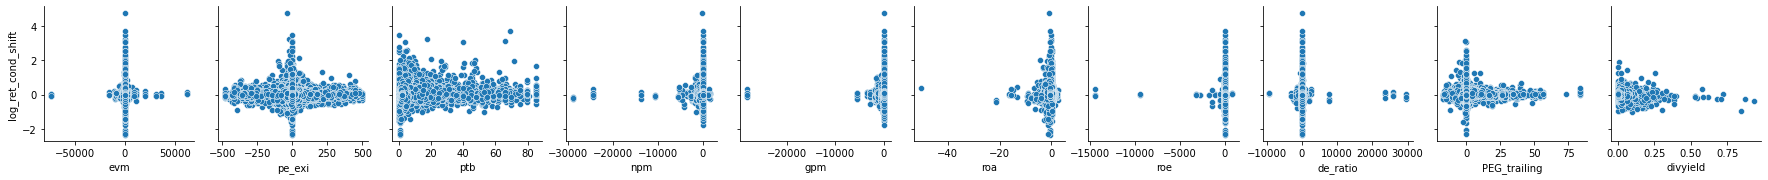

In [198]:
sns.pairplot(data=data,
             y_vars=['log_ret_cond_shift'],
            x_vars=['evm','pe_exi','ptb','npm','gpm','roa','roe','de_ratio','PEG_trailing','divyield'])


In [199]:
dat_filter = data.copy()

dat_filter['log_ret'] = dat_filter['log_ret'][dat_filter['log_ret'].between(dat_filter['log_ret'].quantile(.02),dat_filter['log_ret'].quantile(.98)) ] # without outliers
dat_filter['log_ret_cond_shift'] = dat_filter['log_ret_cond_shift'][dat_filter['log_ret_cond_shift'].between(dat_filter['log_ret_cond_shift'].quantile(.02),dat_filter['log_ret_cond_shift'].quantile(.98)) ] # without outliers
dat_filter['roa'] = dat_filter['roa'][dat_filter['roa'].between(dat_filter['roa'].quantile(.02), dat_filter['roa'].quantile(.98))] # without outliers
dat_filter['roe'] = dat_filter['roe'][dat_filter['roe'].between(dat_filter['roe'].quantile(.02), dat_filter['roe'].quantile(.98))] # without outliers
dat_filter['evm'] = dat_filter['evm'][dat_filter['evm'].between(dat_filter['evm'].quantile(.02), dat_filter['evm'].quantile(.98))] # without outliers
dat_filter['pe_exi'] = dat_filter['pe_exi'][dat_filter['pe_exi'].between(dat_filter['pe_exi'].quantile(.02), dat_filter['pe_exi'].quantile(.98))] # without outliers
dat_filter['ptb'] = dat_filter['ptb'][dat_filter['ptb'].between(dat_filter['ptb'].quantile(.02), dat_filter['ptb'].quantile(.98))] # without outliers
dat_filter['npm'] = dat_filter['npm'][dat_filter['npm'].between(dat_filter['npm'].quantile(.02), dat_filter['npm'].quantile(.98))] # without outliers
dat_filter['gpm'] = dat_filter['gpm'][dat_filter['gpm'].between(dat_filter['gpm'].quantile(.02), dat_filter['gpm'].quantile(.98))] # without outliers
dat_filter['de_ratio'] = dat_filter['de_ratio'][dat_filter['de_ratio'].between(dat_filter['de_ratio'].quantile(.02), dat_filter['de_ratio'].quantile(.98))] # without outliers
dat_filter['PEG_trailing'] = dat_filter['PEG_trailing'][dat_filter['PEG_trailing'].between(dat_filter['PEG_trailing'].quantile(.02), dat_filter['PEG_trailing'].quantile(.98))] # without outliers
dat_filter['divyield'] = dat_filter['divyield'][dat_filter['divyield'].between(dat_filter['divyield'].quantile(.02), dat_filter['divyield'].quantile(.98))] # without outliers


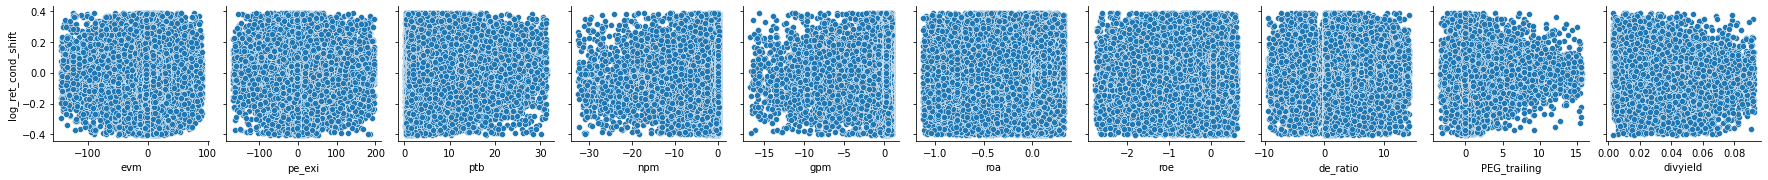

In [200]:
sns.pairplot(data=dat_filter,
             y_vars=['log_ret_cond_shift'],
            x_vars=['evm','pe_exi','ptb','npm','gpm','roa','roe','de_ratio','PEG_trailing','divyield'])


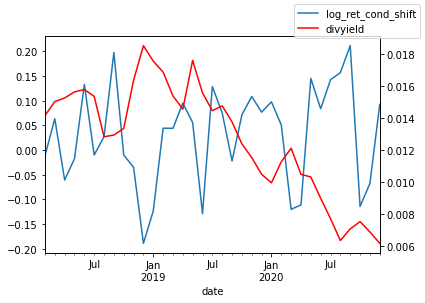

In [201]:
a =dat_filter[dat_filter['TICKER'] == 'AAPL']


ax = a.plot(x="date", y="log_ret_cond_shift", legend=False)
ax2 = ax.twinx()
a.plot(x="date", y="divyield", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

<AxesSubplot:label='fc2b5aca-8b9b-4beb-ae99-f6c6355c0c54'>

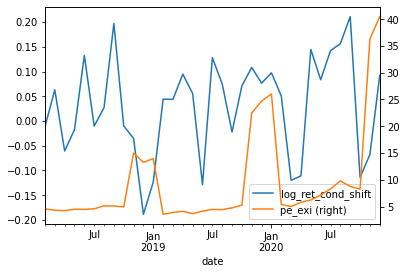

In [202]:
fig, ax = plt.subplots() # Create the figure and axes object

# Plot the first x and y axes:
a.plot(x = 'date', y = 'log_ret_cond_shift', ax = ax) 
# Plot the second x and y axes. By secondary_y = True a second y-axis is requested:
# (see https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html for details)
a.plot(x = 'date', y = 'pe_exi', ax = ax, secondary_y = True) 

In [203]:
sm_ols('log_ret_cond_shift ~ divyield', data=a).fit().summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_ret_cond_shift   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     4.731
Date:                Mon, 26 Apr 2021   Prob (F-statistic):             0.0369
Time:                        22:12:43   Log-Likelihood:                 33.581
No. Observations:                  35   AIC:                            -63.16
Df Residuals:                      33   BIC:                            -60.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1596      0.061      2.598      0.014       0.035       0.285
divyield     -10.1461      4.665     -2.175      0.037     -19.637      -0.655
==============================================================================
Omnibus:                        2.083   Durbin-Watson:                   1.808
Prob(Omnibus):                  0.353   Jarque-Bera (JB):                1.921
Skew:                          -0.502   Prob(JB):                        0.383
Kurtosis:                       2.442   Cond. No.                         289.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### ^ Graph makes it look like there is a relationship while according to OLS regression, there is not

<AxesSubplot:xlabel='pe_exi', ylabel='log_ret_cond_shift'>

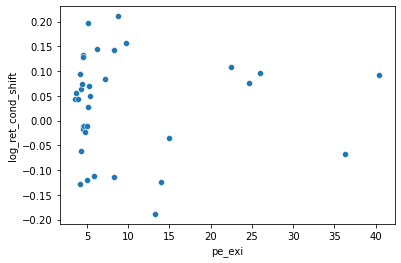

In [204]:
sns.scatterplot(x='pe_exi',y='log_ret_cond_shift',data=a)

In [205]:
data_2019 = dat_filter[dat_filter['year'] == '2019']
data_2020 = dat_filter[dat_filter['year'] == '2020']

sm_ols('log_ret_cond_shift ~ evm + pe_exi + gpm + roe + divyield', data=dat_filter).fit().summary() #R2 = 0.11, obs =  40,387
sm_ols('log_ret_cond_shift ~ evm + pe_exi + gpm + roe + divyield', data=data_2019).fit().summary() #R2 = 0.005, obs =  14,591
sm_ols('log_ret_cond_shift ~ PEG_trailing', data=data_2019).fit().summary() #R2 = 0.005, obs =  14,591


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_ret_cond_shift   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     72.90
Date:                Mon, 26 Apr 2021   Prob (F-statistic):           1.46e-17
Time:                        22:12:43   Log-Likelihood:                 15627.
No. Observations:               20673   AIC:                        -3.125e+04
Df Residuals:                   20671   BIC:                        -3.123e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0056      0.001     -6.295      0.000      -0.007      -0.004
PEG_trailing     0.0036      0.000      8.538      0.000       0.003       0.004
==============================================================================
Omnibus:                      537.979   Durbin-Watson:                   2.201
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              939.284
Skew:                          -0.224   Prob(JB):                    1.09e-204
Kurtosis:                       3.943   Cond. No.                         2.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [207]:
#evm: enterprise value multiple
#pe_exi: price/earnings excluding extraordianry income 
#npm: net profit margin
#gpm: gross profit margin
#roa: retrun on assets
#roe: return on equity
#de_ratio: debt/equity
#ptb: price/book
#PEG_trailing: PEG 12ttm 
#divyield: dividend yield 



In [209]:
# dat_filter_q1 = dat_filter[dat_filter.datadate.str.endswith('03-31')] #filter by rows ending in 3-31
# sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_q1).fit().summary()

In [240]:
def reg_params(df,formula="log_ret_cond_shift ~ evm + pe_exi + gpm + npm + roe + de_ratio + ptb + PEG_trailing + divyield"):
    return pd.Series(sm.formula.ols(formula,data = df).fit().params)


In [243]:
def reg_r2(df,formula="log_ret_cond_shift ~ evm + pe_exi + gpm + npm + roe + de_ratio + ptb + PEG_trailing + divyield"):
    return pd.Series(sm.formula.ols(formula,data = df).fit().rsquared)


In [245]:
table_r2 = (
    dat_filter # grab the data
    
    .groupby(['public_date']).apply(reg_r2)
    .rename(columns={0:'r2'})

    .reset_index()
)
table_r2

,public_date,r2
0,2018-01-31,1.000000
1,2018-02-28,0.075244
2,2018-03-31,0.067220
3,2018-04-30,0.068115
4,2018-05-31,0.057313
5,2018-06-30,0.053357
6,2018-07-31,0.034028
7,2018-08-31,0.049173
8,2018-09-30,0.071133
9,2018-10-31,0.035566


In [246]:
table_param = (
    dat_filter # grab the data
    
    .groupby(['public_date']).apply(reg_params)
    .reset_index()
)
table

,public_date,Intercept,evm,pe_exi,gpm,npm,roe,de_ratio,ptb,PEG_trailing,divyield
0,2018-01-31,-0.000207,0.001361,-0.002012,-0.000223,-0.000084,-0.000018,0.001441,-0.000314,0.000633,-0.000008
1,2018-02-28,0.027175,-0.000372,-0.000075,0.017641,-0.009918,-0.006451,0.000936,0.003907,-0.001272,-0.971693
2,2018-03-31,-0.042301,-0.001477,-0.000127,0.006362,0.098690,-0.112593,0.001347,0.006735,0.001195,-0.215829
3,2018-04-30,0.013131,0.000058,0.000167,0.007599,0.084023,-0.065440,-0.001414,-0.000485,0.002722,-0.676408
4,2018-05-31,0.007997,-0.002232,0.000716,-0.028867,0.103432,-0.109709,0.002647,0.003031,-0.000327,0.105146
5,2018-06-30,0.048142,-0.001026,-0.000635,0.053854,-0.002968,-0.098580,-0.004472,0.005558,0.001571,-0.221588
6,2018-07-31,-0.026646,0.000687,-0.000016,0.052885,-0.103305,0.086303,-0.002558,-0.001192,-0.000603,0.451282
7,2018-08-31,0.037206,0.000149,0.000020,-0.040158,0.008901,-0.013848,-0.000626,0.002154,0.001580,-0.353120
8,2018-09-30,-0.010025,0.000804,0.000249,0.012898,-0.046151,0.029794,0.000379,0.003075,-0.000298,-0.269066
9,2018-10-31,-0.012697,-0.000027,0.000060,-0.027432,-0.000951,-0.018576,-0.000307,0.002625,0.000259,-0.122692


In [250]:
table = pd.merge(table_param, table_r2, on='public_date').round(4)
table

,public_date,Intercept,evm,pe_exi,gpm,npm,roe,de_ratio,ptb,PEG_trailing,divyield,r2
0,2018-01-31,-0.0002,0.0014,-0.0020,-0.0002,-0.0001,-0.0000,0.0014,-0.0003,0.0006,-0.0000,1.0000
1,2018-02-28,0.0272,-0.0004,-0.0001,0.0176,-0.0099,-0.0065,0.0009,0.0039,-0.0013,-0.9717,0.0752
2,2018-03-31,-0.0423,-0.0015,-0.0001,0.0064,0.0987,-0.1126,0.0013,0.0067,0.0012,-0.2158,0.0672
3,2018-04-30,0.0131,0.0001,0.0002,0.0076,0.0840,-0.0654,-0.0014,-0.0005,0.0027,-0.6764,0.0681
4,2018-05-31,0.0080,-0.0022,0.0007,-0.0289,0.1034,-0.1097,0.0026,0.0030,-0.0003,0.1051,0.0573
5,2018-06-30,0.0481,-0.0010,-0.0006,0.0539,-0.0030,-0.0986,-0.0045,0.0056,0.0016,-0.2216,0.0534
6,2018-07-31,-0.0266,0.0007,-0.0000,0.0529,-0.1033,0.0863,-0.0026,-0.0012,-0.0006,0.4513,0.0340
7,2018-08-31,0.0372,0.0001,0.0000,-0.0402,0.0089,-0.0138,-0.0006,0.0022,0.0016,-0.3531,0.0492
8,2018-09-30,-0.0100,0.0008,0.0002,0.0129,-0.0462,0.0298,0.0004,0.0031,-0.0003,-0.2691,0.0711
9,2018-10-31,-0.0127,-0.0000,0.0001,-0.0274,-0.0010,-0.0186,-0.0003,0.0026,0.0003,-0.1227,0.0356


In [252]:
#table.to_csv('betas.csv')

In [302]:
table['year'] = table.public_date.astype(str).str[:4] #get first 4 chars of public_data aka the year 
table.groupby('year').mean()

,Intercept,evm,pe_exi,gpm,npm,roe,de_ratio,ptb,PEG_trailing,divyield,r2
year,,,,,,,,,,,
2018,0.000800,-0.000450,-0.000067,-0.009500,0.053983,-0.056183,0.000083,0.003158,0.000825,-0.139317,0.138817
2019,0.019375,-0.000475,0.000100,-0.020225,0.051850,-0.041608,0.000458,0.002683,-0.000350,-0.325892,0.076233
2020,0.006833,-0.000292,0.000267,-0.032133,0.042950,-0.026475,0.000258,0.003808,0.000367,-0.409717,0.131283


<AxesSubplot:xlabel='public_date', ylabel='values'>

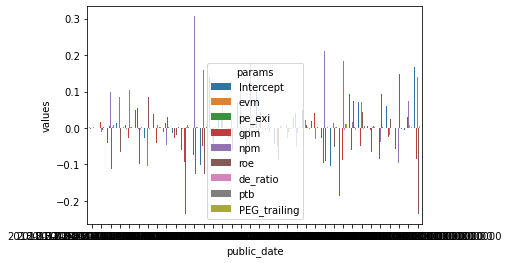

In [137]:
df1 = table.copy()
df1 = df1.drop(columns=['divyield'])
df2 = df1.set_index('public_date').stack().reset_index()
test = df2.rename(columns={'level_1':'params',0:'values'})
test

sns.barplot(x='public_date',y='values',data=test,hue='params')

<AxesSubplot:xlabel='public_date', ylabel='evm'>

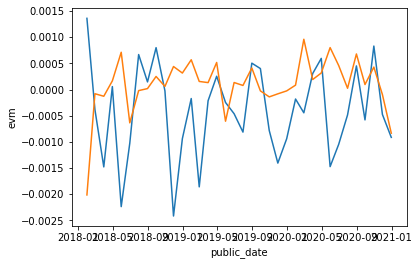

In [108]:
sns.lineplot(x='public_date',y='evm',data=table)
sns.lineplot(x='public_date',y='pe_exi',data=table,ci=95)
#sns.lineplot(x='public_date',y='gpm',data=table)
#sns.lineplot(x='public_date',y='npm',data=table)

/Users/Jordan/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

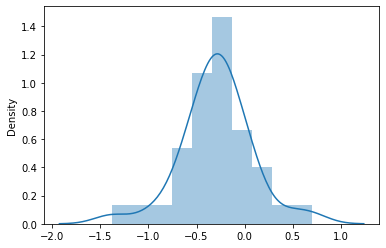

In [154]:
#sns.distplot(x=table['gpm'])
sns.distplot(x=table['divyield'])